In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Carregando base de dados com todos os resultados

In [67]:
df =  pd.read_csv("../results_models/all_results/CISIA-ALL-Experiments.csv")

df_time_moe = pd.read_excel("../Time-MoE/results_model_local/results_time_moe_last_year.xlsx")
df_timefm = pd.read_excel("../TimesFM/results_model_local/times_fm_results_last_year.xlsx")
df_morai = pd.read_excel("../Morai/results_model_local/morai_results_last_year.xlsx")

In [68]:
df_time_moe = df_time_moe[df_time_moe['TYPE_PREDICTIONS'] == 'zeroshot']

### Análise de correlação para cada produto

In [69]:
# INFO: Filtrando apenas os modelos que possuem zero shot
df_filtrado = df[df["GRANU"].str.contains("_ZS", na=False)] 

In [70]:
df_filtrado = df_filtrado[~df_filtrado['MODEL'].isin(['Morai-MoE', 'TimeMoE', 'TimesFM'])]

In [71]:
df_filtrado['MODEL'].unique().tolist()

['Chronos', 'LagLlama', 'TimeGPT']

In [72]:
# Selecionar as colunas desejadas
colunas_fixas = ['PRODUCT', 'UF', 'MODEL', 'PARAMETERS', 'RRMSE', 'MAPE']
colunas_predicoes = [f'P{i}' for i in range(49, 61)]  # Gera a lista de colunas p49 a p60

# Renomear colunas
df_filtrado = df_filtrado[colunas_fixas + colunas_predicoes].rename(columns={
    'PARAMETERS': 'TYPE_MODEL',
    'UF': 'STATE'
})

# Converter colunas de p49 a p60 em uma lista dentro da coluna PREDICTIONS
df_filtrado['PREDICTIONS'] = df_filtrado[colunas_predicoes].values.tolist()

# Remover as colunas individuais de p49 a p60
df_filtrado = df_filtrado.drop(columns=colunas_predicoes)

In [73]:
# Identificar colunas comuns entre os DataFrames
colunas_comuns = list(set(df_time_moe.columns) & set(df_timefm.columns) & set(df_filtrado.columns))

# Manter apenas as colunas comuns em cada DataFrame
df_time_moe = df_time_moe[colunas_comuns]
df_timefm = df_timefm[colunas_comuns]
df_morai = df_morai[colunas_comuns]
df_filtrado = df_filtrado[colunas_comuns]

# Concatenar os três DataFrames
df_final = pd.concat([df_time_moe, df_timefm, df_morai, df_filtrado], ignore_index=True)

# Exibir o DataFrame final
df_final.head()

,MAPE,PRODUCT,PREDICTIONS,MODEL,TYPE_MODEL,STATE,RRMSE
0,0.311281,etanolhidratado,[13893.737 14260.75 14263.308 14066.354 13360...,TimeMoE,TimeMoE_50M,pe,0.487770
1,0.049340,gasolinac,[118058.73 117925.94 116979.87 118475.41 1...,TimeMoE,TimeMoE_50M,pe,0.101437
2,0.608922,gasolinadeaviacao,[30.381958 33.172565 34.42056 36.89269 35.21...,TimeMoE,TimeMoE_50M,pe,0.144938
3,0.039102,glp,[45453.113 43561.92 44817.75 45594.52 47605...,TimeMoE,TimeMoE_50M,pe,0.049899
4,30.507987,oleocombustivel,[ 637.27795 2257.655 3559.523 4647.569...,TimeMoE,TimeMoE_50M,pe,0.499005


### Tabela best results

In [ ]:
# df_final = df_final[df_final['PRODUCT'] == 'etanolhidratado']
df_final = df_final[~df_final['PRODUCT'].isin(['gasolinadeaviacao', 'oleocombustivel', 'queroseneiluminante'])]

In [75]:
# Supondo que seu DataFrame já está carregado como df_filtrado

# Ordenar pelo menor RRMSE dentro de cada grupo de PRODUCT e STATE
df_ranked = df_final.sort_values(by=["PRODUCT", "STATE", "RRMSE"]).groupby(["PRODUCT", "STATE"]).head(5)

# Criar a classificação dentro de cada grupo
df_ranked["rank"] = df_ranked.groupby(["PRODUCT", "STATE"])["MAPE"].rank(method="first")

# Contar quantas vezes cada modelo ficou em cada posição
rank_count = df_ranked.groupby(["MODEL", "rank"]).size().unstack(fill_value=0)

# Exibir os resultados
print(rank_count)


rank      1.0  2.0  3.0  4.0  5.0
MODEL                            
Chronos     9   14   15   20   20
LagLlama    7    1    0    4    2
Morai       1    1    2    0    2
TimeGPT     0    3    3    1    2
TimeMoE     4    2    4    2    0
TimesFM     6    6    3    0    1


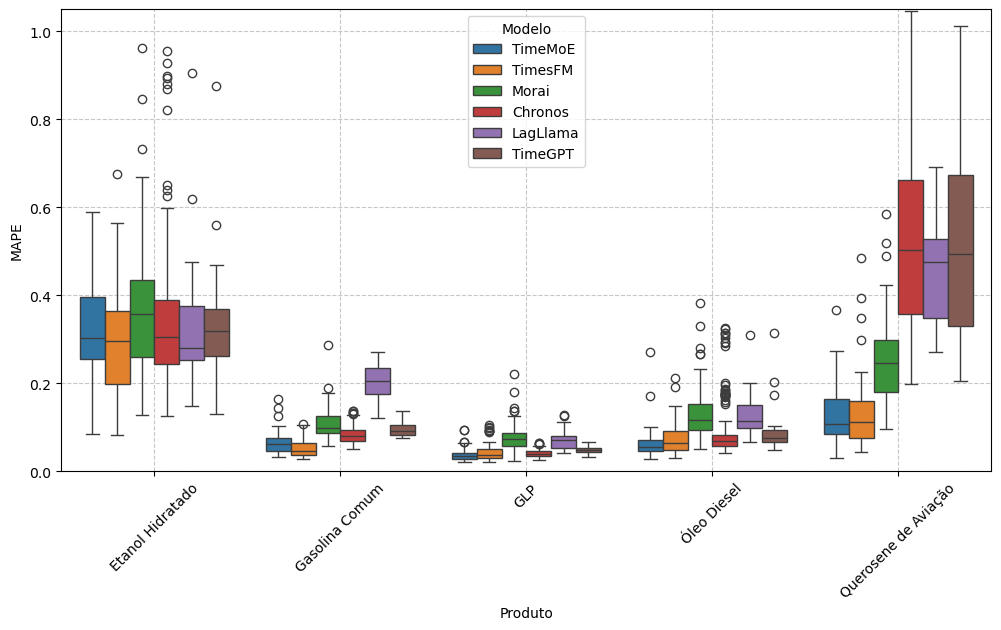

In [35]:
derivados = {
    'etanolhidratado': 'Etanol Hidratado',
    'gasolinac': 'Gasolina Comum',
    'glp': 'GLP',
    'oleodiesel': 'Óleo Diesel',
    'querosenedeaviacao': 'Querosene de Aviação'
}

df_final['PRODUCT'] = df_final['PRODUCT'].replace(derivados)

# Criar o box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="PRODUCT", y="MAPE", hue="MODEL", data=df_final)
plt.xlabel("Produto")
plt.ylabel("MAPE")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.ylim(0, 1.05)
plt.show()

### Modelos Estatisticos

In [88]:
import pandas as pd
import glob
import os

# Define o diretório base onde estão os resultados
base_dir = "../results_models/statistical_models"

# Cria um padrão para buscar recursivamente todos os arquivos CSV que comecem com "transform_"
pattern = os.path.join(base_dir, "**", "transform_*.csv")
csv_files = glob.glob(pattern, recursive=True)

# Lista para armazenar os DataFrames lidos
df_list = []

# Loop para ler cada arquivo CSV encontrado
for file in csv_files:
    try:
        df = pd.read_csv(file, sep=';')
        df_list.append(df)
    except Exception as e:
        print(f"Erro ao ler o arquivo {file}: {e}")

# Verifica se encontrou algum arquivo
if df_list:
    # Concatena todos os DataFrames em um único DataFrame
    df_all = pd.concat(df_list, ignore_index=True)
    
    # Filtra as linhas onde 'train_range' é igual a '1990-01_2023-02'
    df_filtered = df_all[df_all['train_range'] == '1990-01_2023-02']
    
    # Exibe o DataFrame filtrado
    print(df_filtered)
else:
    print("Nenhum arquivo CSV encontrado.")


          train_range       test_range  UF     PRODUCT  MODEL  \
0     1990-01_2023-02  2023-03_2024-02  RJ         glp    ETS   
6     1990-01_2023-02  2023-03_2024-02  CE         glp    ETS   
12    1990-01_2023-02  2023-03_2024-02  AM         glp    ETS   
18    1990-01_2023-02  2023-03_2024-02  SE         glp    ETS   
24    1990-01_2023-02  2023-03_2024-02  MS         glp    ETS   
...               ...              ...  ..         ...    ...   
5860  1990-01_2023-02  2023-03_2024-02  SP  oleodiesel  ARIMA   
5876  1990-01_2023-02  2023-03_2024-02  MG  oleodiesel  ARIMA   
5892  1990-01_2023-02  2023-03_2024-02  MA  oleodiesel  ARIMA   
5908  1990-01_2023-02  2023-03_2024-02  SC  oleodiesel  ARIMA   
5924  1990-01_2023-02  2023-03_2024-02  MT  oleodiesel  ARIMA   

                                                 PARAMS  WINDOW  HORIZON  \
0     {'trend': 'add', 'seasonal': 'add', 'seasonal_...      12       12   
6     {'trend': 'add', 'seasonal': 'add', 'seasonal_...      12    

In [93]:
derivados = {
    'etanolhidratado': 'Etanol Hidratado',
    'gasolinac': 'Gasolina Comum',
    'glp': 'GLP',
    'oleodiesel': 'Óleo Diesel',
    'querosenedeaviacao': 'Querosene de Aviação'
}

df_filtered['PRODUCT'] = df_filtered['PRODUCT'].replace(derivados)

/tmp/ipykernel_2010766/1935611083.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PRODUCT'] = df_filtered['PRODUCT'].replace(derivados)


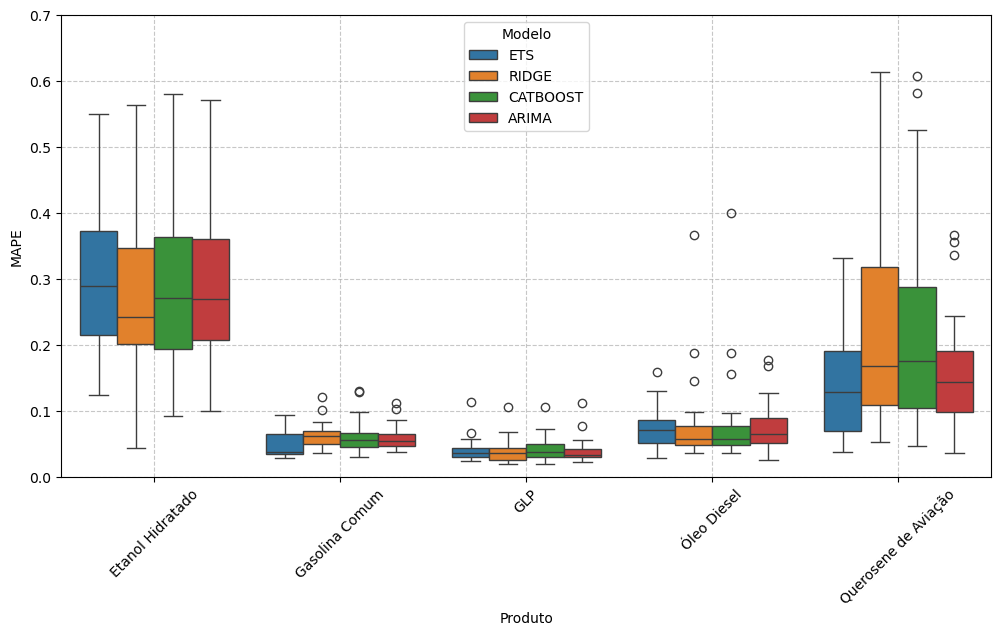

In [97]:
# Define a ordem desejada para o eixo X
order = ["Etanol Hidratado", "Gasolina Comum", "GLP", "Óleo Diesel", "Querosene de Aviação"]

# Criar o box plot com a ordem definida
plt.figure(figsize=(12, 6))
sns.boxplot(x="PRODUCT", y="MAPE", hue="MODEL", data=df_filtered, order=order)
plt.xlabel("Produto")
plt.ylabel("MAPE")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.ylim(0, 0.7)
plt.show()


### Correlação

In [32]:
def plot_correlations(df):
    for product, group in df.groupby("PRODUCT"):
        model_series = {}

        for model, model_group in group.groupby("MODEL"):
            # Extrair todas as predições P1 a P60 e achatar para um único array
            pred_values = model_group[['P' + str(i) for i in range(1, 61)]].values.flatten()

            # Remover valores NaN antes de concatenar
            pred_values = pred_values[~np.isnan(pred_values)]

            # Garantir que temos valores suficientes para calcular a correlação
            if len(pred_values) > 0:
                model_series[model] = pred_values

        # Criar DataFrame das séries para calcular a correlação
        model_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in model_series.items()])).fillna(0)

        # Criar matriz de correlação
        correlation_matrix = model_df.corr()

        # Criar figura
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f'Correlação entre Modelos - {product}')
        plt.xlabel("Modelos")
        plt.ylabel("Modelos")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()


In [ ]:
plot_correlations(df_filtrado)